<h1 align="center">The Surprise of Double Descent</h1>
<hr style="border:2px solid gray">

### Import python packages
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression

---
### Data set
---
We use the following dataset and fit it with Legendre polynomials of various degrees $p$.

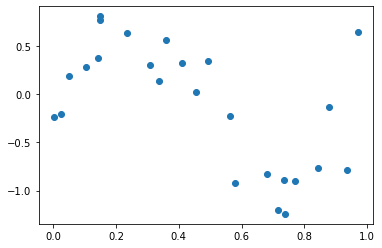

In [ ]:
data = np.array([
    0.001399613, -0.23436656,
    0.971629779,  0.64689524,
    0.579119475, -0.92635765,
    0.335693937,  0.13000706,
    0.736736086, -0.89294863,
    0.492572335,  0.33854780,
    0.737133774, -1.24171910,
    0.563693769, -0.22523318,
    0.877603280, -0.12962722,
    0.141426545,  0.37632006,
    0.307203910,  0.30299077,
    0.024509308, -0.21162739,
    0.843665029, -0.76468719,
    0.771206067, -0.90455412,
    0.149670258,  0.77097952,
    0.359605608,  0.56466366,
    0.049612895,  0.18897607,
    0.409898906,  0.32531750,
    0.935457898, -0.78703491,
    0.149476207,  0.80585375,
    0.234315216,  0.62944986,
    0.455297119,  0.02353327,
    0.102696671,  0.27621694,
    0.715372314, -1.20379729,
    0.681745393, -0.83059624 ]).reshape(25,2)
y = data[:,1]
X = data[:,0:1]

plt.scatter(X[:,0], y)
plt.show()

---
### Linear regressor class
---

We use the following linear regressor class for all double descent examples. It takes only the first $p$ columns from the feature matrix $F$ and computes the minimum $\ell_2$-norm solution when $n < p$.

In [ ]:
class MyRidgeRegressor:
    def __init__(self, p=3, alpha=0.0):
        self.p     = p
        self.theta = None
        self.alpha = alpha

    def fit(self, F, y):
        F = F[:, 0:self.p]
        self.theta = np.linalg.pinv(F.transpose()@F + self.alpha*np.identity(F.shape[1]))@F.transpose()@y

    def predict(self, F):
        F = F[:, 0:self.p]
        return F@self.theta

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def get_params(self, deep=True):
        return {"p" : self.p, "alpha" : self.alpha}

---
### Model evaluation
---

We will eventually evaluate the test error of this model by using leave-one-out cross validation where we predict for a single data point we did not train on.

In [ ]:
def evaluate_model(fg, X, y, n, ps, runs=10):
    estimator = MyRidgeRegressor()
    result = None
    for i in range(runs):
        F, y = fg(X, y, n, np.max(ps), random_state=i)

        clf = GridSearchCV(estimator=estimator,
                            param_grid=[{ 'p': list(ps) }],
                            cv=LeaveOneOut(),
                            scoring="neg_mean_squared_error")
        clf.fit(F, y)

        if result is None:
            result  = -clf.cv_results_['mean_test_score']
        else:
            result += -clf.cv_results_['mean_test_score']

    return result / runs

---
#  Legendre polynomial Regression
---

Please fit the data by varying the number of Legender polynomials $p$ we use as features. Slowly increase $p$ (for example: $p=10,30,50,100,200,300,500,1000$).

In [ ]:
class LegendrePolynomialFeatures():
    def __call__(self, X, y, n, p, random_state=42):
        x = X if len(X.shape) == 1 else X[:,0]
        F = np.array([]).reshape(x.shape[0], 0)
        # Generate polynomial features
        for deg in range(p):
            l = np.polynomial.legendre.Legendre([0]*deg + [1], domain=[0,1])
            F = np.insert(F, deg, l(x), axis=1)
        return F, y

---
### Demonstration
---

In [ ]:
F, _ = LegendrePolynomialFeatures()(X, y, len(y), 1000)
g = np.linspace(0, 1, 10000)
G, _ = LegendrePolynomialFeatures()(g, y, len(y), 1000)

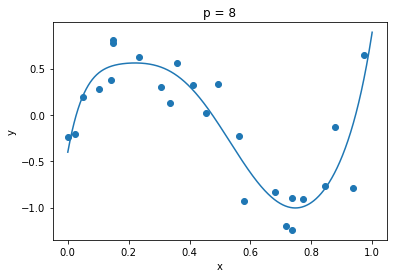

In [ ]:
clf = MyRidgeRegressor(p=8)
clf.fit(F, y)
plt.plot(g, clf.predict(G))
plt.scatter(X, y)
plt.title("p = 8")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

---
### Results
---

In [ ]:
ps = list(range(3, 20)) + [30, 50, 100, 150, 200, 300, 400, 500, 1000]
result = evaluate_model(LegendrePolynomialFeatures(), X, y, len(y), ps, runs=1)

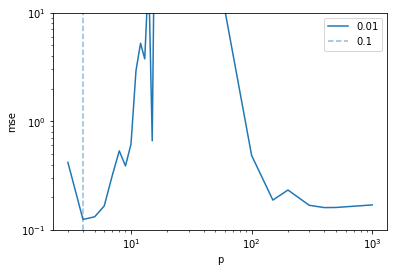

In [ ]:
p = plt.plot(ps, result)
plt.axvline(x=ps[np.argmin(result)], color=p[0].get_color(), alpha=0.5, linestyle='--')
plt.legend(scales)
plt.xscale("log")
plt.xlabel("p")
plt.yscale("log")
plt.ylim(0.1,10)
plt.ylabel("mse")
plt.show()